In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

brent = pd.read_csv("datathon data/crude_oil/BRENT.csv")
makeup = pd.read_csv("datathon data/monthly_gasoline_makeup_percentages.csv")
makeup = makeup[makeup['Type'] == 'Regular']
gas_prices = pd.read_csv("datathon data/gas_prices/regular_formulated_gas_prices.csv")

brent = brent.rename({"Price":"Brent_Price"}, axis=1)
# Ensure dates are in datetime format
makeup['Date'] = pd.to_datetime(makeup['Date'])
gas_prices['Date'] = pd.to_datetime(gas_prices['Date'])
brent['Date'] = pd.to_datetime(brent['Date'])

# Extract Year and Month in both DataFrames
makeup['Year'] = makeup['Date'].dt.year
makeup['Month'] = makeup['Date'].dt.month
gas_prices['Year'] = gas_prices['Date'].dt.year
gas_prices['Month'] = gas_prices['Date'].dt.month
brent['Year'] = brent['Date'].dt.year
brent['Month'] = brent['Date'].dt.month

## Data Processing
- Three datasets are used:
  -  makeup: Monthly composition of gasoline prices (e.g. Refining, Taxes).
  - gas_prices: Weekly gasoline retail prices.
  - brent: Daily crude oil prices.
- Alignment of time frequencies:
  - Monthly makeup data is interpolated to weekly values using linear interpolation.
  - Daily brent prices are aggregated to weekly averages.
  - The result  **gas_brent_linear** is a weekly-aligned dataset with: Weekly gas prices, Weekly estimates of the components (Refining, Taxes, etc.), Weekly Brent crude oil averages.

### Interpolate Monthly Makeup to Weekly
- same values for this month
- linearly interpolate

In [33]:
makeup.columns

Index(['Date_String', 'Date', 'Retail_Price', 'Refining',
       'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Type', 'Year',
       'Month'],
      dtype='object')

In [34]:
# Identify the first weekly entry of each month
first_week = gas_prices.groupby(['Year', 'Month'])['Date'].min().reset_index()
gas_prices_same = pd.merge(gas_prices, makeup, on=['Year', 'Month'], how='left').drop(columns=['Date_y', 'Date_String']).rename({"Date_x":"Date"}, axis=1)

# Merge with monthly makeup data on Year and Month
merged = pd.merge(first_week, makeup, on=['Year', 'Month'], how='left')

# Now map these monthly values back to the gas_prices DataFrame
gas_prices_combined = pd.merge(gas_prices, merged[['Date_x', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil']], 
                      left_on='Date', right_on='Date_x', how='left')

# Drop the merge helper column
gas_prices_combined.drop(columns='Date_x', inplace=True)

gas_prices_linear = gas_prices_combined

# Interpolate the missing values linearly
for col in ['Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil']:
    gas_prices_linear[col] = gas_prices_linear[col].interpolate(method='linear', limit_direction='both')


### Aggregate Brent to Weekly (average)

In [35]:
brent

,Date,Brent_Price,Commodity,Commodity_Simple,Unit,Year,Month
0,2024-01-22,81.70,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
1,2024-01-19,80.71,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
2,2024-01-18,81.04,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
3,2024-01-17,78.88,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
4,2024-01-16,80.15,Brent Crude Oil,BRENT,Dollars per Barrel,2024,1
...,...,...,...,...,...,...,...
9564,1987-05-26,18.63,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9565,1987-05-25,18.60,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9566,1987-05-22,18.55,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5
9567,1987-05-21,18.45,Brent Crude Oil,BRENT,Dollars per Barrel,1987,5


In [36]:
brent_weekly = brent.resample('W-MON', on='Date')['Brent_Price'].mean().reset_index()
gas_brent_linear = pd.merge(gas_prices_linear, brent_weekly, on='Date', how ='inner')
gas_brent_same = pd.merge(gas_prices_same, brent_weekly, on='Date', how ='inner')

In [37]:
gas_brent_linear.to_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_linear.csv")
gas_brent_same.to_csv("datathon data/gas_prices/regular_formulated_gas_prices_rf_same.csv")

In [38]:
gas_brent_linear.columns

Index(['Date', 'Year', 'Type', 'Type_Clean', 'Unit', 'Geography', 'Price',
       'Month', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price'],
      dtype='object')

### Feature Engineering

Computes log-returns and percentage changes for:
- Retail gasoline prices,
- Each price component (Refining, Taxes, etc.),
- Crude oil prices.
- Generates lagged features (e.g., previous 1 to 4 months' returns) to examine delayed effects.

In [39]:
import numpy as np
# Get the pct and logreturn
for col in ['Price', 'Brent_Price', 'Refining', 'Taxes', 'Distribution_and_Marketing', 'Crude_Oil']:
    gas_brent_linear[f'{col}_logreturn'] = np.log(gas_brent_linear[col] / gas_brent_linear[col].shift(1))
    gas_brent_linear[f'{col}_pct'] = gas_brent_linear[col].pct_change()
    gas_brent_same[f'{col}_logreturn'] = np.log(gas_brent_same[col] / gas_brent_same[col].shift(1))
    gas_brent_same[f'{col}_pct'] = gas_brent_same[col].pct_change()

lag = 1
gas_brent_linear[f'Price_lag_{lag}'] = gas_brent_linear['Price'].shift(lag)

/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/yangzejia/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Train XGBoost and Random Forest

**Aim**: Use weekly-level data to build a predictive model for gasoline price or its change (log-return or pct change).


**Approach**:
- Use Random Forest or XGBoost for prediction.
- Train model using:
  - Log-returns or pct changes of interpolated components.
  - Weekly crude oil changes.
- Extract feature importances to assess which factors matter most.

In [40]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

['Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
MSE: 0.0002180098406373604
Feature Importantce                                 feature  importance
2                       Taxes_logreturn    0.459666
0                 Brent_Price_logreturn    0.210025
3  Distribution_and_Marketing_logreturn    0.150990
4                   Crude_Oil_logreturn    0.099743
1                    Refining_logreturn    0.079575


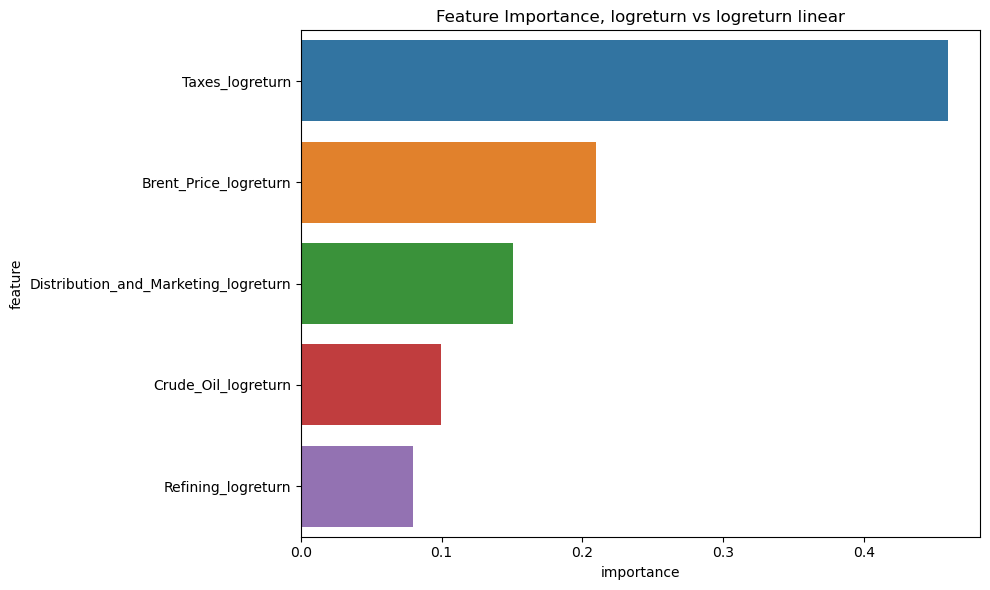

In [41]:
# Drop NA rows due to lag
gas_brent_linear = gas_brent_linear.dropna()

# Features and target, to fit log return 
feature_cols = [col for col in gas_brent_linear.columns if '_logreturn' in col and col != 'Price_logreturn']
print(feature_cols)
X = gas_brent_linear[feature_cols]
y = gas_brent_linear['Price_logreturn']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance)
plt.title("Feature Importance, logreturn vs logreturn linear")
plt.tight_layout()
plt.show()


In [44]:
# Features and target, to fit log return 
feature_cols = [
    f'Price_lag_{lag}',
        'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price', 'Brent_Price_logreturn',
        'Refining_logreturn',
       'Taxes_logreturn',  'Distribution_and_Marketing_logreturn',
        'Crude_Oil_logreturn',
       ]
print(feature_cols)
X = gas_brent_linear[feature_cols]
y = gas_brent_linear['Price']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)

['Price_lag_1', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Brent_Price', 'Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
MSE: 0.04018138611553872
Feature Importantce                                  feature  importance
0                            Price_lag_1    0.497407
3                                  Taxes    0.474233
5                            Brent_Price    0.025346
9   Distribution_and_Marketing_logreturn    0.000624
1                               Refining    0.000520
6                  Brent_Price_logreturn    0.000432
7                     Refining_logreturn    0.000372
4                              Crude_Oil    0.000346
8                        Taxes_logreturn    0.000330
10                   Crude_Oil_logreturn    0.000233
2             Distribution_and_Marketing    0.000156


In [43]:
feature_cols = [f'Price_lag_{lag}',
        'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price', 'Brent_Price_logreturn',
        'Refining_logreturn',
       'Taxes_logreturn',  'Distribution_and_Marketing_logreturn',
        'Crude_Oil_logreturn',
       ]
print(feature_cols)
X = gas_brent_linear[feature_cols]
y = gas_brent_linear['Price_logreturn']  # or 'Price' or 'Price_pct'

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))

importance = model.feature_importances_
feat_importance = pd.DataFrame({'feature': X.columns, 'importance': importance})
feat_importance = feat_importance.sort_values('importance', ascending=False)

print("Feature Importantce", feat_importance)


['Price_lag_1', 'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Brent_Price', 'Brent_Price_logreturn', 'Refining_logreturn', 'Taxes_logreturn', 'Distribution_and_Marketing_logreturn', 'Crude_Oil_logreturn']
MSE: 0.0002495436916790246
Feature Importantce                                  feature  importance
8                        Taxes_logreturn    0.387661
6                  Brent_Price_logreturn    0.200507
9   Distribution_and_Marketing_logreturn    0.126760
7                     Refining_logreturn    0.051389
10                   Crude_Oil_logreturn    0.041090
2             Distribution_and_Marketing    0.040006
1                               Refining    0.038232
4                              Crude_Oil    0.032703
5                            Brent_Price    0.031938
3                                  Taxes    0.027106
0                            Price_lag_1    0.022607


### correlation test

<Axes: >

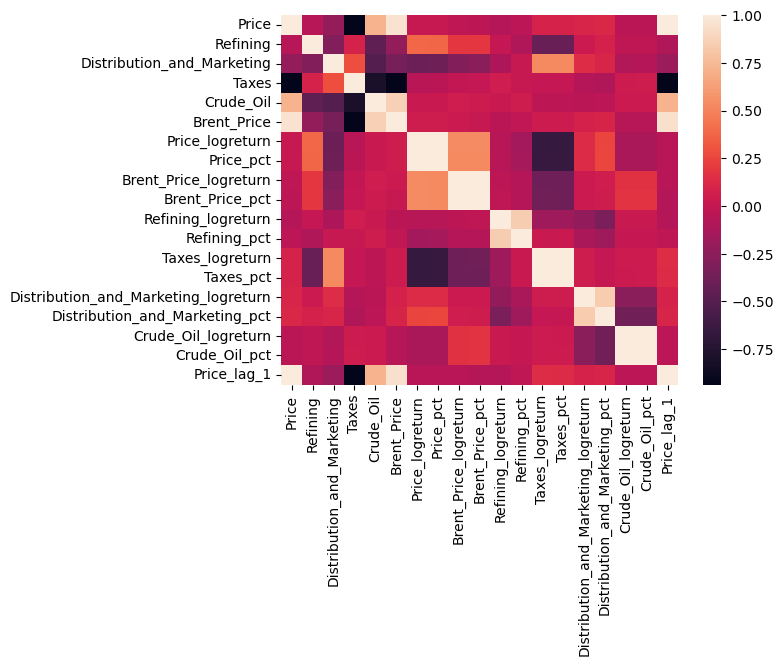

In [51]:
m = gas_brent_linear[['Price',
       'Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil',
       'Brent_Price', 'Price_logreturn', 'Price_pct', 'Brent_Price_logreturn',
       'Brent_Price_pct', 'Refining_logreturn', 'Refining_pct',
       'Taxes_logreturn', 'Taxes_pct', 'Distribution_and_Marketing_logreturn',
       'Distribution_and_Marketing_pct', 'Crude_Oil_logreturn',
       'Crude_Oil_pct', 'Price_lag_1']].corr()

sns.heatmap(m)

                    Price  Price_logreturn  Price_pct  Price_lag_1
Price            1.000000         0.013373   0.012948     0.997284
Price_logreturn  0.013373         1.000000   0.999590    -0.057182
Price_pct        0.012948         0.999590   1.000000    -0.057642
Price_lag_1      0.997284        -0.057182  -0.057642     1.000000


Text(0.5, 1.0, 'Heatmap: Target Features Correlation')

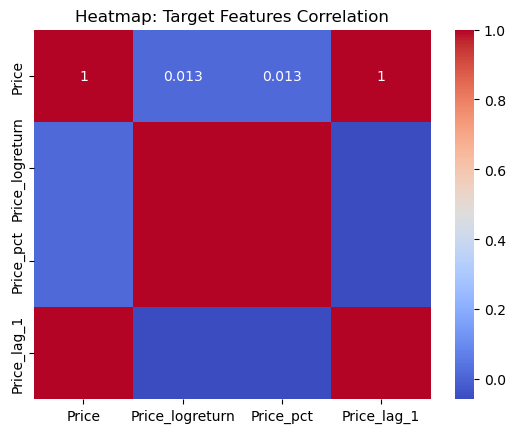

In [52]:
target_cols = ['Price', 'Price_logreturn', 'Price_pct', 'Price_lag_1']
print(m.loc[target_cols, target_cols])
sns.heatmap(m.loc[target_cols, target_cols], annot=True, cmap='coolwarm')
plt.title("Heatmap: Target Features Correlation")

                 Refining  Distribution_and_Marketing     Taxes  Crude_Oil  \
Price           -0.066054                   -0.212463 -0.935838   0.716285   
Price_logreturn  0.380588                   -0.400458 -0.051760   0.023436   
Price_pct        0.378456                   -0.395132 -0.051008   0.021465   
Price_lag_1     -0.092063                   -0.184678 -0.931030   0.713704   

                 Brent_Price  
Price               0.951105  
Price_logreturn     0.043164  
Price_pct           0.041759  
Price_lag_1         0.946235  


Text(0.5, 1.0, 'Heatmap: Target vs Component Levels')

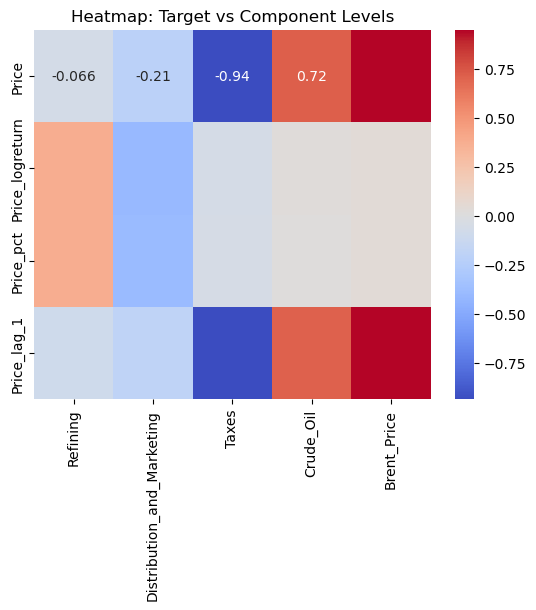

In [53]:
component_level = ['Refining', 'Distribution_and_Marketing', 'Taxes', 'Crude_Oil', 'Brent_Price']
print(m.loc[target_cols, component_level])
sns.heatmap(m.loc[target_cols, component_level], annot=True, cmap='coolwarm')
plt.title("Heatmap: Target vs Component Levels")

                 Refining_logreturn  Distribution_and_Marketing_logreturn  \
Price                     -0.079775                              0.100488   
Price_logreturn           -0.061696                              0.133068   
Price_pct                 -0.059889                              0.132894   
Price_lag_1               -0.076441                              0.091768   

                 Taxes_logreturn  Crude_Oil_logreturn  Brent_Price_logreturn  
Price                   0.091841            -0.045197              -0.020958  
Price_logreturn        -0.657144            -0.117627               0.533683  
Price_pct              -0.651903            -0.119964               0.530410  
Price_lag_1             0.138264            -0.036689              -0.057162  


Text(0.5, 1.0, 'Heatmap: Target vs Component Log Returns')

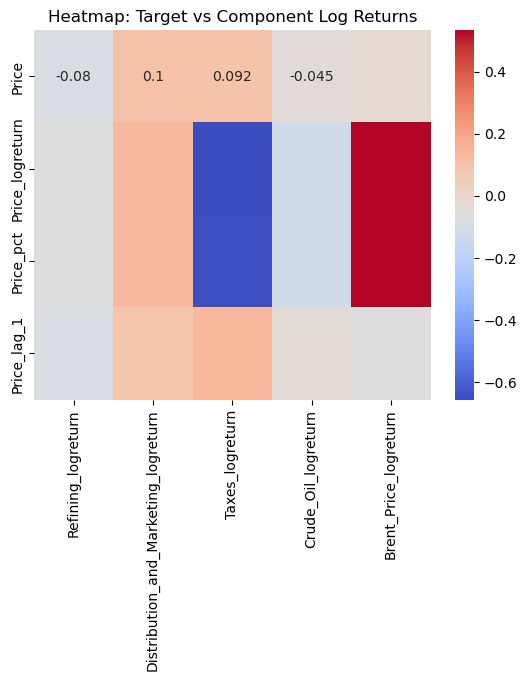

In [55]:
log_returns = ['Refining_logreturn', 'Distribution_and_Marketing_logreturn', 'Taxes_logreturn', 'Crude_Oil_logreturn', 'Brent_Price_logreturn']
print(m.loc[target_cols,  log_returns])
sns.heatmap(m.loc[target_cols, log_returns], annot=True, cmap='coolwarm')
plt.title("Heatmap: Target vs Component Log Returns")

                 Refining_pct  Distribution_and_Marketing_pct  Taxes_pct  \
Price               -0.036878                        0.121968   0.091277   
Price_logreturn     -0.142840                        0.251255  -0.657988   
Price_pct           -0.137397                        0.252212  -0.652461   
Price_lag_1         -0.027200                        0.105790   0.137781   

                 Crude_Oil_pct  Brent_Price_pct  
Price                -0.047878        -0.030282  
Price_logreturn      -0.119822         0.532726  
Price_pct            -0.122122         0.529843  
Price_lag_1          -0.039228        -0.066489  


Text(0.5, 1.0, 'Heatmap: Target vs Component % Changes')

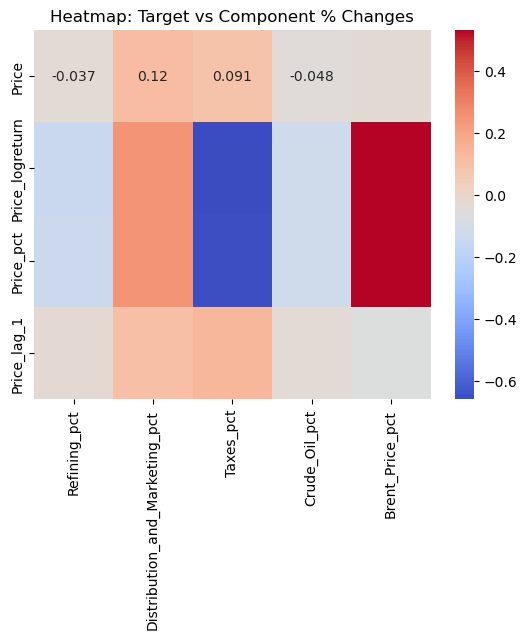

In [56]:
pct_changes = ['Refining_pct', 'Distribution_and_Marketing_pct', 'Taxes_pct', 'Crude_Oil_pct', 'Brent_Price_pct']
print(m.loc[target_cols, pct_changes])
sns.heatmap(m.loc[target_cols, pct_changes], annot=True, cmap='coolwarm')
plt.title("Heatmap: Target vs Component % Changes")